<a href="https://colab.research.google.com/github/meganhsu/ML100-Days/blob/master/Day_016_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 練習時間
將你的結果存成 csv, 上傳你的第一份 Kaggle 成績

Hints: https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file

In [0]:
# Import 需要的套件
import os
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 之前做過的處理

In [0]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])


### 做好前處理
開始擬合模型之前，我們要確保 training & testing data 的欄位數量一致，原因是因為 One hot encoding 會製造多的欄位，有些類別出現在 training data 而沒有出現 testing data 中，我們就要把這些多餘的欄位去除

In [0]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

In [0]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(labels = ['TARGET'], axis=1)
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### Fit the model

In [0]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! (記得要用 predict_proba 才會輸出機率)

In [0]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

### 儲存預測結果

In [0]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.065051
1,100005,0.126401
2,100013,0.081239
3,100028,0.061509
4,100038,0.128308


In [0]:
submit.to_csv('creditRiskPredict.csv',index=False)


In [0]:
submit

,SK_ID_CURR,TARGET
0,100001,0.065051
1,100005,0.126401
2,100013,0.081239
3,100028,0.061509
4,100038,0.128308
5,100042,0.055894
6,100057,0.083035
7,100065,0.125470
8,100066,0.050359
9,100067,0.103295


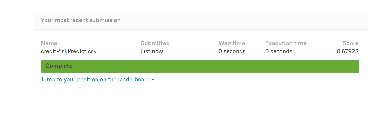

In [0]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

lena = mpimg.imread('Day16_messageImage_1555597650106.jpg') # 读取和代码处于同一目录下的 lena.png
# 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
lena.shape #(512, 512, 3)

plt.imshow(lena) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()